# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [Kornia]((https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb))
* [imgaug]((https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb)). 

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

In [1]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

Before we start, let's install the `datasets` and `transformers` libraries.

In [2]:
!pip install -q datasets transformers

     |████████████████████████████████| 365 kB 6.0 MB/s 
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 115 kB 61.8 MB/s 
     |████████████████████████████████| 212 kB 47.5 MB/s 
     |████████████████████████████████| 120 kB 54.9 MB/s 
     |████████████████████████████████| 127 kB 71.8 MB/s 
     |████████████████████████████████| 6.6 MB 64.5 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store



Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
#dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")
dataset = load_dataset("imagefolder", data_files="/content/drive/MyDrive/AI_and_ML/VOSAP2022Hackathon-0827.zip")

# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: just load any existing dataset from the hub, like CIFAR-10, FashionMNIST ...
# dataset = load_dataset("cifar10")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-1e5ffc04f0523b56/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 39
    })
})

To access an actual element, you need to select a split first, then give an index:

In [9]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=176x92 at 0x7F5117DAD1D0>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [10]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=2, names=['Canes', 'NoCanes'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

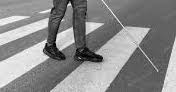

In [11]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

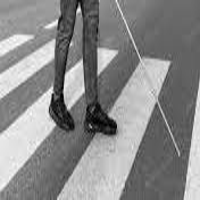

In [12]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [13]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [14]:
dataset["train"].features["label"]

ClassLabel(num_classes=2, names=['Canes', 'NoCanes'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [15]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0]

'Canes'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [16]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing). 

In [17]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [18]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [19]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [20]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=828x532 at 0x7F5090165510>,
 'label': 0,
 'pixel_values': tensor([[[-1.2788, -1.2959, -1.2959,  ...,  1.7865,  1.7694,  1.7180],
          [-1.2788, -1.2959, -1.3130,  ...,  1.7523,  1.7352,  1.7180],
          [-1.2959, -1.3130, -1.3130,  ...,  1.7352,  1.7523,  1.7523],
          ...,
          [ 0.2624,  0.2282,  0.5022,  ...,  0.6563,  0.4166,  0.4679],
          [ 0.2453,  0.3994,  0.4508,  ...,  0.6563,  0.2796,  0.3138],
          [ 0.3481,  0.5878,  0.5878,  ...,  0.6392,  0.1254,  0.0056]],
 
         [[-1.1779, -1.1954, -1.1954,  ...,  1.9559,  1.9384,  1.8859],
          [-1.1779, -1.1954, -1.2129,  ...,  1.9209,  1.9034,  1.8859],
          [-1.1954, -1.2129, -1.2129,  ...,  1.9034,  1.9209,  1.9209],
          ...,
          [ 0.3978,  0.3627,  0.6429,  ...,  0.8004,  0.5553,  0.6078],
          [ 0.3803,  0.5378,  0.5903,  ...,  0.8004,  0.4153,  0.4503],
          [ 0.4853,  0.7304,  0.7304,  ...,  0.7829, 

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head. 

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [22]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-vosap",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    #num_train_epochs=3,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [23]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [24]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap into local empty directory.


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [26]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 35
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.540201,0.750000
2,No log,0.532863,0.750000
3,No log,0.540449,1.000000


***** Running Evaluation *****
  Num examples = 4
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-1
Configuration saved in swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-1/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-1/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-1/preprocessor_config.json
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-vosap/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-2
Configuration saved in swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-2/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-2/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-vosap/checkpoint-2/preprocessor_confi

Upload file pytorch_model.bin:   0%|          | 3.34k/105M [00:00<?, ?B/s]

Upload file runs/Sep05_21-28-45_4d01f37efe8d/events.out.tfevents.1662413376.4d01f37efe8d.71.0:  65%|######5   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap
   461770a..48b4ec0  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap
   461770a..48b4ec0  main -> main

To https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap
   48b4ec0..1bbd3e0  main -> main

   48b4ec0..1bbd3e0  main -> main



***** train metrics *****
  epoch                    =        3.0
  total_flos               =  2430639GF
  train_loss               =     0.3704
  train_runtime            = 0:00:17.29
  train_samples_per_second =       6.07
  train_steps_per_second   =      0.173


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [27]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4
  Batch size = 32


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =        1.0
  eval_loss               =     0.5404
  eval_runtime            = 0:00:00.08
  eval_samples_per_second =     47.792
  eval_steps_per_second   =     11.948


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [28]:
trainer.push_to_hub()

Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-vosap
Configuration saved in swin-tiny-patch4-window7-224-finetuned-vosap/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-vosap/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-vosap/preprocessor_config.json


Upload file runs/Sep05_21-28-45_4d01f37efe8d/events.out.tfevents.1662413599.4d01f37efe8d.71.2: 100%|##########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap
   1bbd3e0..339b675  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap
   1bbd3e0..339b675  main -> main



'https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/commit/339b675ba97d3c57b9a18f2ee8e1e3bf16118394'

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a satellite image of a forest (that's not part of the EuroSAT dataset), and see how the model does.

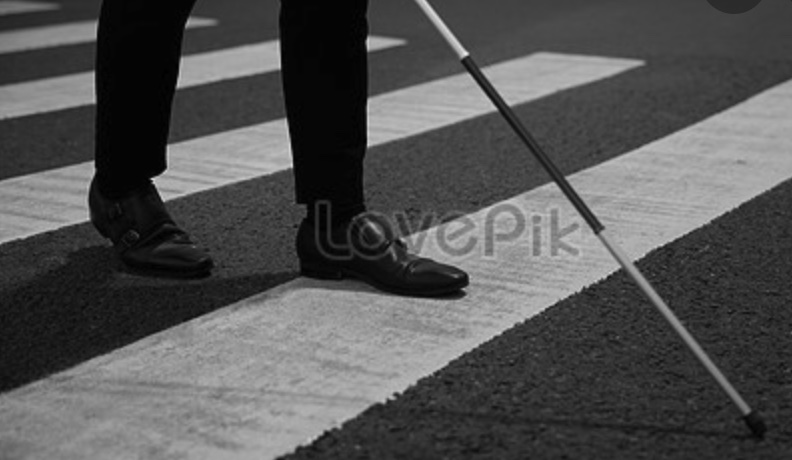

In [29]:
from PIL import Image
import requests

#url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
#image = Image.open(requests.get(url, stream=True).raw)
#url = '/content/drive/MyDrive/AI_and_ML/nocane_evaluation.jpg'
url = '/content/drive/MyDrive/AI_and_ML/cane_evaluation.jpg'
image = Image.open(url)
image

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [31]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpq2xh7awh


storing https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/63d84633c77f534504675240b15bcc49716da5d4be54739332e0f9780d228a68.e34548f8325ec440fcf4990d4a8dbbfd665397400e9a700766de032d2b45cf6b
creating metadata file for /root/.cache/huggingface/transformers/63d84633c77f534504675240b15bcc49716da5d4be54739332e0f9780d228a68.e34548f8325ec440fcf4990d4a8dbbfd665397400e9a700766de032d2b45cf6b
loading feature extractor configuration file https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/63d84633c77f534504675240b15bcc49716da5d4be54739332e0f9780d228a68.e34548f8325ec440fcf4990d4a8dbbfd665397400e9a700766de032d2b45cf6b
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    

storing https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/5105a84c7ca1db1297c2eadeff20d23e4d8efe27fffbc8340e52566f970fdffd.e7083acf0571e2a0e544233f115361fdc8730374a18de0d5e35a3839e422fcfb
creating metadata file for /root/.cache/huggingface/transformers/5105a84c7ca1db1297c2eadeff20d23e4d8efe27fffbc8340e52566f970fdffd.e7083acf0571e2a0e544233f115361fdc8730374a18de0d5e35a3839e422fcfb
loading configuration file https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/5105a84c7ca1db1297c2eadeff20d23e4d8efe27fffbc8340e52566f970fdffd.e7083acf0571e2a0e544233f115361fdc8730374a18de0d5e35a3839e422fcfb
Model config SwinConfig {
  "_name_or_path": "RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
 

storing https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/76e34b4f56b98bcb889030d36c1d48a8e62024d13ecbf8442355bcd267c9b942.32570802436c4703a0c9fa1cec6f52bb57d13ac66dd70fde7462a11bccd206a4
creating metadata file for /root/.cache/huggingface/transformers/76e34b4f56b98bcb889030d36c1d48a8e62024d13ecbf8442355bcd267c9b942.32570802436c4703a0c9fa1cec6f52bb57d13ac66dd70fde7462a11bccd206a4
loading weights file https://huggingface.co/RohanK447/swin-tiny-patch4-window7-224-finetuned-vosap/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/76e34b4f56b98bcb889030d36c1d48a8e62024d13ecbf8442355bcd267c9b942.32570802436c4703a0c9fa1cec6f52bb57d13ac66dd70fde7462a11bccd206a4
All model checkpoint weights were used when initializing SwinForImageClassification.

All the weights of SwinForImageClassification were initialized from the model checkpoint at RohanK447/swin-tin

In [32]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [33]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [34]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: NoCanes


Looks like our model got it correct! 

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Let's showcase this for our trained model:

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", "nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat")

loading configuration file https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/83e4a1dea85e8e284e4da8ae1e3cf950c2c7e74d65a5a188049b3371fcd151bd.f1ed4852dd8f4c3d0c565427607bc41fff51b58ac73a0970bec8456e5c64cea0
Model config SwinConfig {
  "_name_or_path": "nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "

In [ ]:
pipe(image)

[{'label': 'Forest', 'score': 0.7000269889831543},
 {'label': 'HerbaceousVegetation', 'score': 0.14589950442314148},
 {'label': 'Pasture', 'score': 0.10370415449142456},
 {'label': 'Highway', 'score': 0.014327816665172577},
 {'label': 'Residential', 'score': 0.0139168007299304}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and feature extractors:

In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=feature_extractor)

In [ ]:
pipe(image)

[{'label': 'Forest', 'score': 0.7000269889831543},
 {'label': 'HerbaceousVegetation', 'score': 0.14589950442314148},
 {'label': 'Pasture', 'score': 0.10370415449142456},
 {'label': 'Highway', 'score': 0.014327816665172577},
 {'label': 'Residential', 'score': 0.0139168007299304}]